In [1]:
%matplotlib inline

import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sentinelhub import (
    CRS,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
    parse_time,
    BBox,
    bbox_to_dimensions,
)


/Users/octave.lepinard/Desktop/notebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Intro to ARPS data in Planet Insights Platform

Welcome to an intro to using Analysis Ready Planet Scope (ARPS) within the Planet Insights Platform (PIP). In this demo we are going to be using the ARPS tile near Perth, Australia that is available within the [Planet Sandbox](https://collections.sentinel-hub.com/analysis-ready-planetscope/sandbox-data.html). We will be observing the changing water level of a reservoir throughout the year. 

* Step 1: Visualize imagery using the Processing API

* Step 2: Create a time series using the Statistical API

* Step 3: Water classifiaction using thresholds

If this is your first time using the Sentinel Hub APIs, please [check configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials that you can find [here](https://apps.sentinel-hub.com/dashboard/#/account/settings).

<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0; line-height: 1.5;">
        This notebook makes use of <a href="https://collections.sentinel-hub.com/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://www.sentinel-hub.com/create_account/" target="_blank">create a free 30 day trial</a>.
      </p>
    </div>
    <div style="flex: 0 0 50%; display: flex; justify-content: center; align-items: center;">
      <a href="https://www.sentinel-hub.com/create_account/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        white-space: nowrap;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>


In [2]:
config = SHConfig()
#If you dont want to set up the configuration file, you can set up the configuration here manualy
if not config.sh_client_id:
    config.sh_client_id = '' # CHANGE THIS
    config.sh_client_secret = '' # CHANGE THIS

assert config.sh_client_id and config.sh_client_secret

In [3]:
#This is the collection ID for the sandbox collection 
collection_id = "3f605f75-86c4-411a-b4ae-01c896f0e54e"

#Coordinates for Lake C.Y. O'Connor outside of Perth, Western Australia
lake_aoi = (116.16437,-31.970731, 116.182909,-31.955166)


In [4]:
#Resolution of the ARPS
resolution = 3

#Create a bounding box for the lake
lake_bbox = BBox(bbox=lake_aoi, crs=CRS.WGS84)
lake_size = bbox_to_dimensions(lake_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {lake_size} pixels")

Image shape at 3 m resolution: (580, 580) pixels


## Step 1: Visualize imagery using the Processing API
### Visualize RGB

In order to visualize imagery from Sentinel Hub we need to use evalscripts, the javascript instructions for the Processing API, [described in more details here](https://docs.sentinel-hub.com/api/latest/evalscript/). This script takes the Red, Green, Blue band of APRS data and divides the values by 1000 as the API will return values between 0-255 and the ARPS data is a SR reflectance product that spans approximately 0-10,000.

In [5]:
vis_eval = """
//VERSION=3
//True Color

function setup() {
  return {
    input: ["blue", "green", "red", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  return [sample.red/1000, sample.green/1000, sample.blue/1000, sample.dataMask];
}
"""

### ATTENTION! 
ARPS data is a fusion of multiple images on the same day, meaning it has no time attribute, just a date. The imagery is tagged at `00:00:00`, to avoid unwanted outputs specify the aquisition time as midday, straddling the midnight timeslot that ARPS is set to. 

The ARPS metadata does include the scene IDs, which are timestamps, however SH does not allow you to access the metadata as of now. If you are hosting your own ARPS data however that information is available.

In [6]:
# Now we make a processing api call to the get the mean value of each pixel for the AOI and the date range.
def request_data(eval, start, end):
    data_collection = DataCollection.define_byoc(collection_id)

    return SentinelHubRequest(  # Create a request for the mean value
        evalscript=eval,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(start, end)
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=lake_bbox,
        size=lake_size,
        config=config,

        data_folder="../data",
    )

vis =  request_data(vis_eval,"2023-03-02T12:00:00Z", "2023-03-03T12:00:00Z") 


In [7]:
visual = vis.get_data()[0]

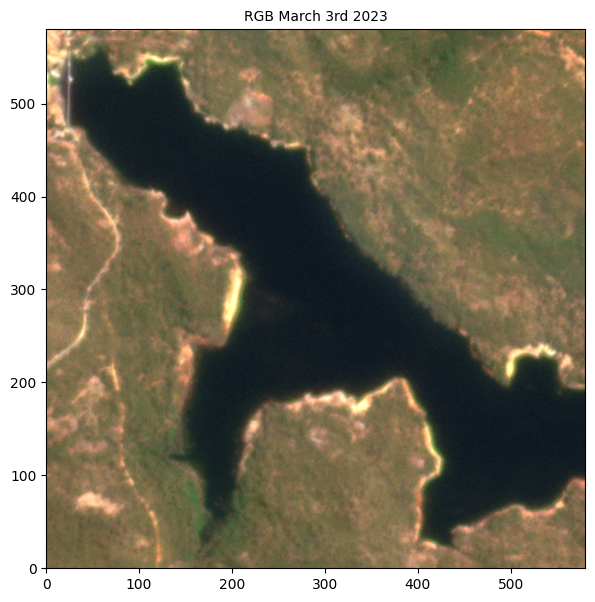

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

ax = axs
aspect_ratio = lake_size[1] / lake_size[0]  # Calculate the aspect ratio
ax.imshow(visual, aspect=aspect_ratio, extent=[0, lake_size[0], 0, lake_size[1]])
ax.set_title(f"RGB March 3rd 2023", fontsize=10)

plt.show()

### Visualize NDWI

Using the Processing API we are not just bound to RGB images, evalscripts can return any multi-band imagery that has the same data type. In this case we are going to calculate the Normalized Difference Water Index and return a 32 bit floating point band. 

In [9]:
ndwi_eval = """
//VERSION=3
//NDWI

function setup() {
  return {
    input: ["green", "nir", "dataMask"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}

function evaluatePixel(sample) {
  var ndwi = (sample.green - sample.nir ) / (sample.green  + sample.nir );
  return [ndwi];
}
"""

In [10]:
ndwi = request_data(ndwi_eval,"2023-03-02T12:00:00Z", "2023-03-03T12:00:00Z").get_data()[0]

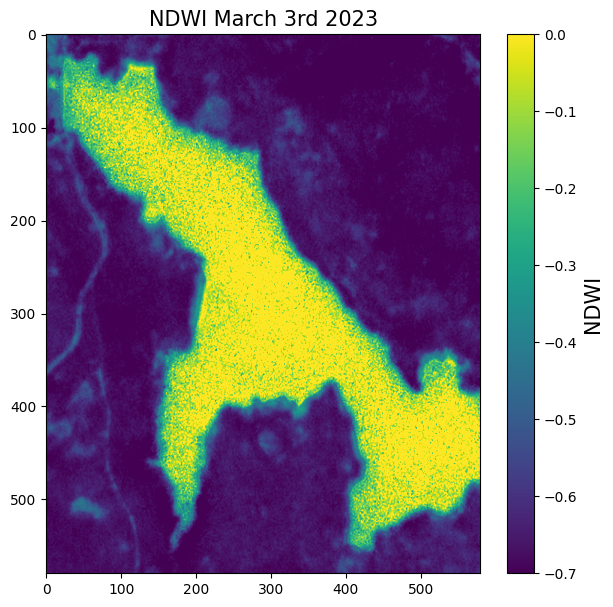

In [11]:

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 7))

# Plot the first raster
cax1 = ax1.imshow(ndwi, cmap="viridis", aspect="auto", vmin=-0.7, vmax=0)
ax1.set_title("NDWI March 3rd 2023", fontsize=15)

# Add colorbar for the first raster
cbar1 = fig.colorbar(cax1, ax=ax1, orientation="vertical")
cbar1.set_label("NDWI", fontsize=15)




## Step 2: Create a time series using the Statistical API

Using the Statistical API we can calculate the mean NDWI value over the whole AOI for every day that we have data. We are going to filter out all non-clear pixels using the ARPS cloud mask which labels clear pixels as 1. More info on the ARPS cloud mask can be found in the [ARPS tech specs](https://developers.planet.com/docs/data/analysis-ready-ps/).

In [12]:
ndwi_time_eval = """
//VERSION=3

function setup() {
    return {
        input: [
            {
                bands: [
                    "green",
                    "nir",
                    "cloud_mask",
                    "dataMask"
                ]
            }
        ],
        output: [
            {
                id: "default",
                bands: 1,
                sampleType: "FLOAT32"
            },
            {
                id: "dataMask",
                bands: 1
            }
        ]
    };
}


function evaluatePixel(sample) {

    var noCloudMask = 0
    if (sample.cloud_mask==1){
        noCloudMask = 1
    }
    const clear = sample.dataMask * noCloudMask;
    var ndwi = (sample.green - sample.nir ) / (sample.green  + sample.nir );

    return {
        default: [ndwi],
        dataMask: [clear]
    };
}
"""

In [13]:
def get_stats(collection_id, eval):
    # Pulling in data from a colleciton
    data_collection = DataCollection.define_byoc(collection_id)

    # Stat API calc that calculates NDWI within a date range and the AOI for all available imagery
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=eval,
            time_interval=("2022-04-30T12:00:00Z", "2023-04-30T12:00:00Z"),
            aggregation_interval="P1D",
            size=lake_size,
        ),
        input_data=[SentinelHubStatistical.input_data(data_collection, maxcc=1)],
        bbox=lake_bbox,
        config=config,
    )
    return request.get_data()[0]

In [14]:
result =  get_stats(collection_id, ndwi_time_eval)

The response of the stats request has the min, max, mean and standard deviation value of each day, for each band, in this case only 1. But it is not in a useful format for analyzing so we must exctract the data we are interested in.

In [15]:
#Feel free to print all of result, it is just quite long
result['data'][0]

{'interval': {'from': '2022-04-30T12:00:00Z', 'to': '2022-05-01T12:00:00Z'},
 'outputs': {'default': {'bands': {'B0': {'stats': {'min': -0.8246780037879944,
      'max': 0.5118110179901123,
      'mean': -0.5152671171905309,
      'stDev': 0.3010599733719118,
      'sampleCount': 336400,
      'noDataCount': 0}}}}}}

In [16]:
def stats_to_df(stats):
    """Converts the statistics returned by the SentinelHubStatistical request to a pandas DataFrame.
    It also cleans the data and changes the column names to be more user-friendly."""
    stats_copy = stats.copy()
    stats_df = pd.json_normalize(stats_copy["data"])

    # Add more of these if there are more bands
    stats_df.columns = stats_df.columns.str.replace("outputs.default.bands.B0.stats.", "ndwi_")

    # Rename columns
    # We select interval.to due to ARPS data being tagged as captured on 00:00:00
    stats_df = stats_df.rename(columns={"interval.to": "date"})
    stats_df = stats_df.drop(columns=['interval.from'])

    stats_df["date"] = stats_df["date"].apply(parse_time).dt.date
    stats_df = stats_df.set_index("date")


    stats_df = stats_df.apply(pd.to_numeric, errors='coerce')
    

    return stats_df

In [17]:
results = stats_to_df(result)

In [18]:
results

ndwi_min  ndwi_max  ndwi_mean  ndwi_stDev  ndwi_sampleCount  \
date                                                                      
2022-05-01 -0.824678  0.511811  -0.515267    0.301060            336400   
2022-05-02 -0.800738  0.957747  -0.512586    0.315765            336400   
2022-05-03 -0.824721  0.834862  -0.505696    0.326402            336400   
2022-05-04       NaN       NaN        NaN         NaN            336400   
2022-05-05 -0.834788  0.564356  -0.501384    0.336489            336400   
...              ...       ...        ...         ...               ...   
2023-04-26 -0.835702  0.971326  -0.541043    0.278983            336400   
2023-04-27       NaN       NaN        NaN         NaN            336400   
2023-04-28 -0.822434  0.666667  -0.555752    0.240172            336400   
2023-04-29 -0.830823  0.700000  -0.534226    0.288643            336400   
2023-04-30 -0.831620  0.855072  -0.555640    0.257716            336400   

            ndwi_noDataCount  
date                          
2022-05-01                 0  
2022-05-02                 0  
2022-05-03                 0  
2022-05-04            336400  
2022-05-05                90  
...                      ...  
2023-04-26             21207  
2023-04-27            336400  
2023-04-28                62  
2023-04-29                36  
2023-04-30                 0  

[296 rows x 6 columns]

Now we have a dataset but you will notice that there are some dates that have NaN values throughout. ARPS is a tiled 24 km X 24 km product. On each given day it will process and mosaic all PS imagery and generate a full tile. Some days only part of the tile will be covered by imagery and the AOI is not, which results in NaN values. Other times an image may have been captured but the entirety of the AOI was covered in clouds so it was masked out, during the filtering that occurs in the evalscript. 

Lastly there are days where a portion of the image will have data but not all of it. Because there is some data present, values will be calculated for NDWI but they will only be representative of the part of the image that has data. Since the portion of the image that has data is random we also want to remove these dates when trying to get a ratio of water to land within an image.

Lets graph the `noDataCount` column in order to get a sense of the distribution.

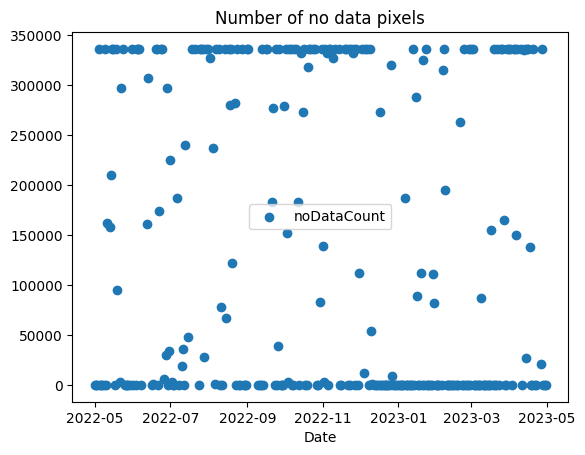

In [19]:
# Plotting the data
plt.scatter(results.index, results['ndwi_noDataCount'], label='noDataCount')


# Adding labels and title
plt.xlabel('Date')
plt.title('Number of no data pixels')
plt.legend()

# Displaying the plot
plt.show()

Lets remove any day that is not entirely covered. Earlier we saw that there were 558,000 pixels total in this AOI

In [20]:
results = results[results['ndwi_noDataCount'] <= 0]
results


ndwi_min  ndwi_max  ndwi_mean  ndwi_stDev  ndwi_sampleCount  \
date                                                                      
2022-05-01 -0.824678  0.511811  -0.515267    0.301060            336400   
2022-05-02 -0.800738  0.957747  -0.512586    0.315765            336400   
2022-05-03 -0.824721  0.834862  -0.505696    0.326402            336400   
2022-05-06 -0.829947  0.551724  -0.495912    0.344833            336400   
2022-05-07 -0.824033  0.734375  -0.487523    0.350503            336400   
...              ...       ...        ...         ...               ...   
2023-04-11 -0.807211  0.882353  -0.537444    0.262667            336400   
2023-04-18 -0.823982  0.543478  -0.531854    0.277199            336400   
2023-04-19 -0.831897  0.935484  -0.503540    0.326548            336400   
2023-04-21 -0.885350  0.853282  -0.520973    0.301142            336400   
2023-04-30 -0.831620  0.855072  -0.555640    0.257716            336400   

            ndwi_noDataCount  
date                          
2022-05-01                 0  
2022-05-02                 0  
2022-05-03                 0  
2022-05-06                 0  
2022-05-07                 0  
...                      ...  
2023-04-11                 0  
2023-04-18                 0  
2023-04-19                 0  
2023-04-21                 0  
2023-04-30                 0  

[122 rows x 6 columns]

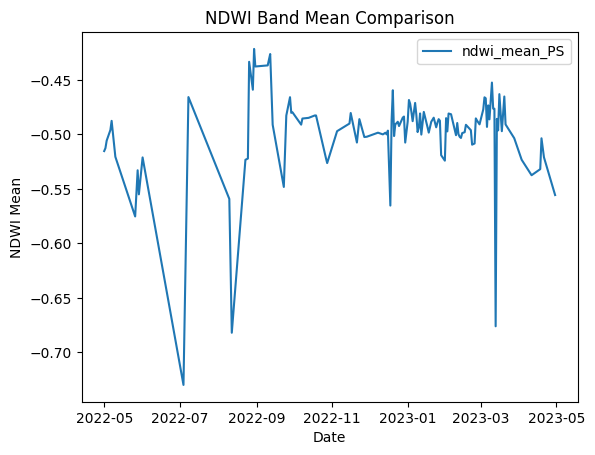

In [21]:
# Plotting the data
plt.plot(results.index, results['ndwi_mean'], label='ndwi_mean_PS')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('NDWI Mean')
plt.title('NDWI Band Mean Comparison')
plt.legend()

# Displaying the plot
plt.show()

The change in NDWI values throughout the year signifies a change in wetness in our AOI. The lower the mean NDWI value the dryer the region which we would imagine would lead to a smaller lake. To confirm this hypothesis we can rudimentarily classify the imagery throughout the year and measure the lake area. 

## Step 3: Water classifiaction using thresholds

We are going to take our NDWI image from earlier and play around with thresholds for classification. Starting at -.6, the highest mean value and slowly working our way up until only the lake outline remains

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# Play around with the threshold value till you get a good binary image of the lake
binary = ndwi > -0.4
cax1 = ax1.imshow(binary, cmap="Blues", aspect="auto")
ax1.set_title("Water Mask September 29th 2022", fontsize=15)

Text(0.5, 1.0, 'Water Mask September 29th 2022')

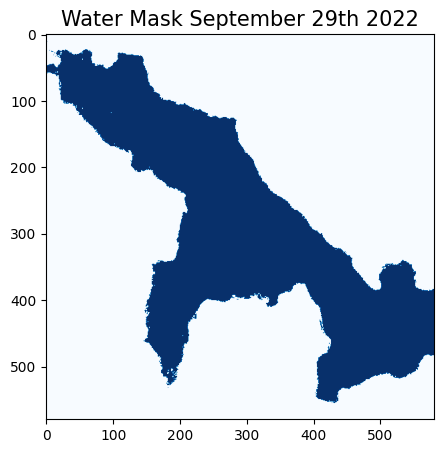

In [23]:

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# Play around with the threshold value till you get a good binary image of the lake
binary = ndwi > -0.4
cax1 = ax1.imshow(binary, cmap="Blues", aspect="auto")
ax1.set_title("Water Mask September 29th 2022", fontsize=15)


#### Given a threshold we can count the number of pixels above and below that value within our image 

Sentinel Hub has the capability of analyzing multiple images within a time range. This can allow for calculating the mean of RGB or NDWI value per pixel for a given month. Here is the evalscript that will take the sum of each pixel and divide it by the number of pixels present in the time range.

In [24]:
mean_eval = """
//VERSION=3
function setup() {
  return {
    input: ["green", "nir", "dataMask", "cloud_mask"],
    output: { bands: 1,
    sampleType: "FLOAT32"},
    mosaicking: "ORBIT"
  };
}

function evaluatePixel(samples, scenes) {
  var sum_ndwi = 0;
  var count = 0;
  for (var i = 0; i < samples.length; i++) {
    var noCloud = samples[i].cloud_mask == 1 ? 1 : 0;
    var total_mask = samples[i].dataMask * noCloud;
    if (total_mask != 0) {
      sum_ndwi += (samples[i].green - samples[i].nir) / (samples[i].green + samples[i].nir);
      count++;
    }
  }
  return [sum_ndwi / count];
}
"""

Now if we make the call for every month that we have imagery for, starting April 2022. This will take a couple minutes.

In [25]:
year = 2022
start_month = 5
monthly_rasters = []

for i in range(12):
    month = (start_month + i - 1) % 12 + 1
    if month == 1 and i != 0:
        year += 1

    # Get the first day of the month
    first_day = datetime(year, month, 1).strftime('%Y-%m-%d')
    # Get the last day of the month
    last_day = datetime(year, month, calendar.monthrange(year, month)[1]).strftime('%Y-%m-%d')
    print(f"Getting data for {first_day} to {last_day}")
    
    monthly_rasters.append(request_data(mean_eval, first_day, last_day).get_data()[0])

Getting data for 2022-05-01 to 2022-05-31
Getting data for 2022-06-01 to 2022-06-30
Getting data for 2022-07-01 to 2022-07-31
Getting data for 2022-08-01 to 2022-08-31
Getting data for 2022-09-01 to 2022-09-30
Getting data for 2022-10-01 to 2022-10-31
Getting data for 2022-11-01 to 2022-11-30
Getting data for 2022-12-01 to 2022-12-31
Getting data for 2023-01-01 to 2023-01-31
Getting data for 2023-02-01 to 2023-02-28
Getting data for 2023-03-01 to 2023-03-31
Getting data for 2023-04-01 to 2023-04-30


Lets look at what the ndwi values for the year look like before we classify our imagery

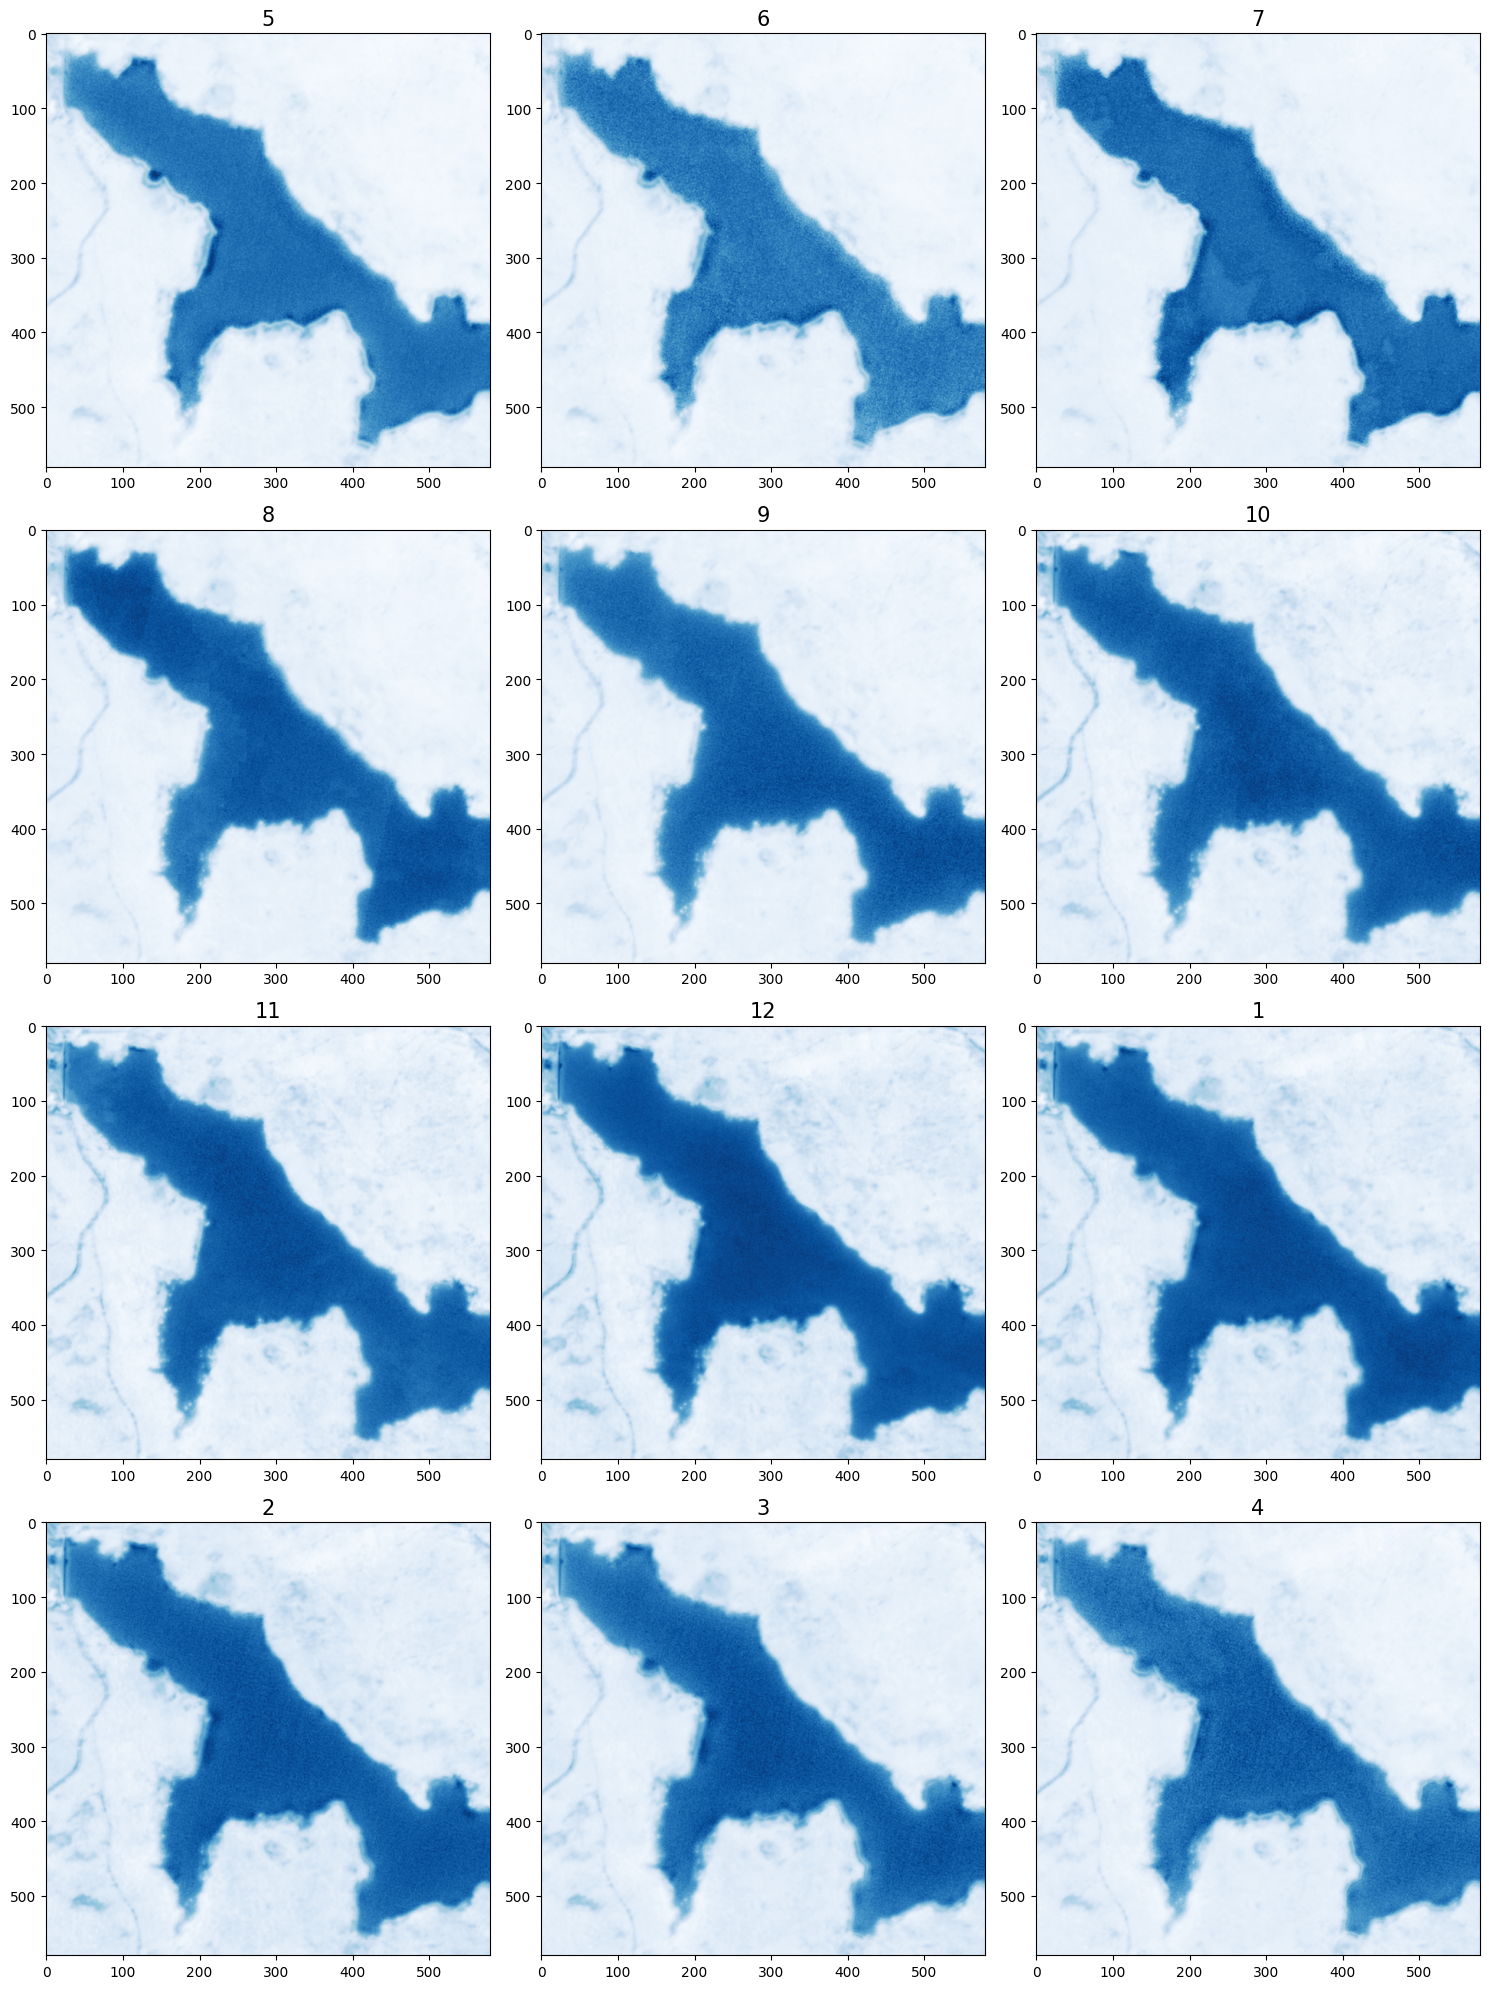

In [26]:
def plot_ndwi_array(ndwi_array, cmap="Blues"):

    # Create subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ndwi in enumerate(ndwi_array):
        # Plot each NDWI raster
        binary = ndwi
        cax = axes[i].imshow(binary, cmap=cmap, aspect="auto")
        # Set title for each subplot
        axes[i].set_title(str((start_month + i - 1) % 12 + 1), fontsize=15)

    # Add colorbar for each subplot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming ndwi_list is a list of NDWI arrays
plot_ndwi_array(monthly_rasters)


Now we can plot all of the images using the threshold that we found above

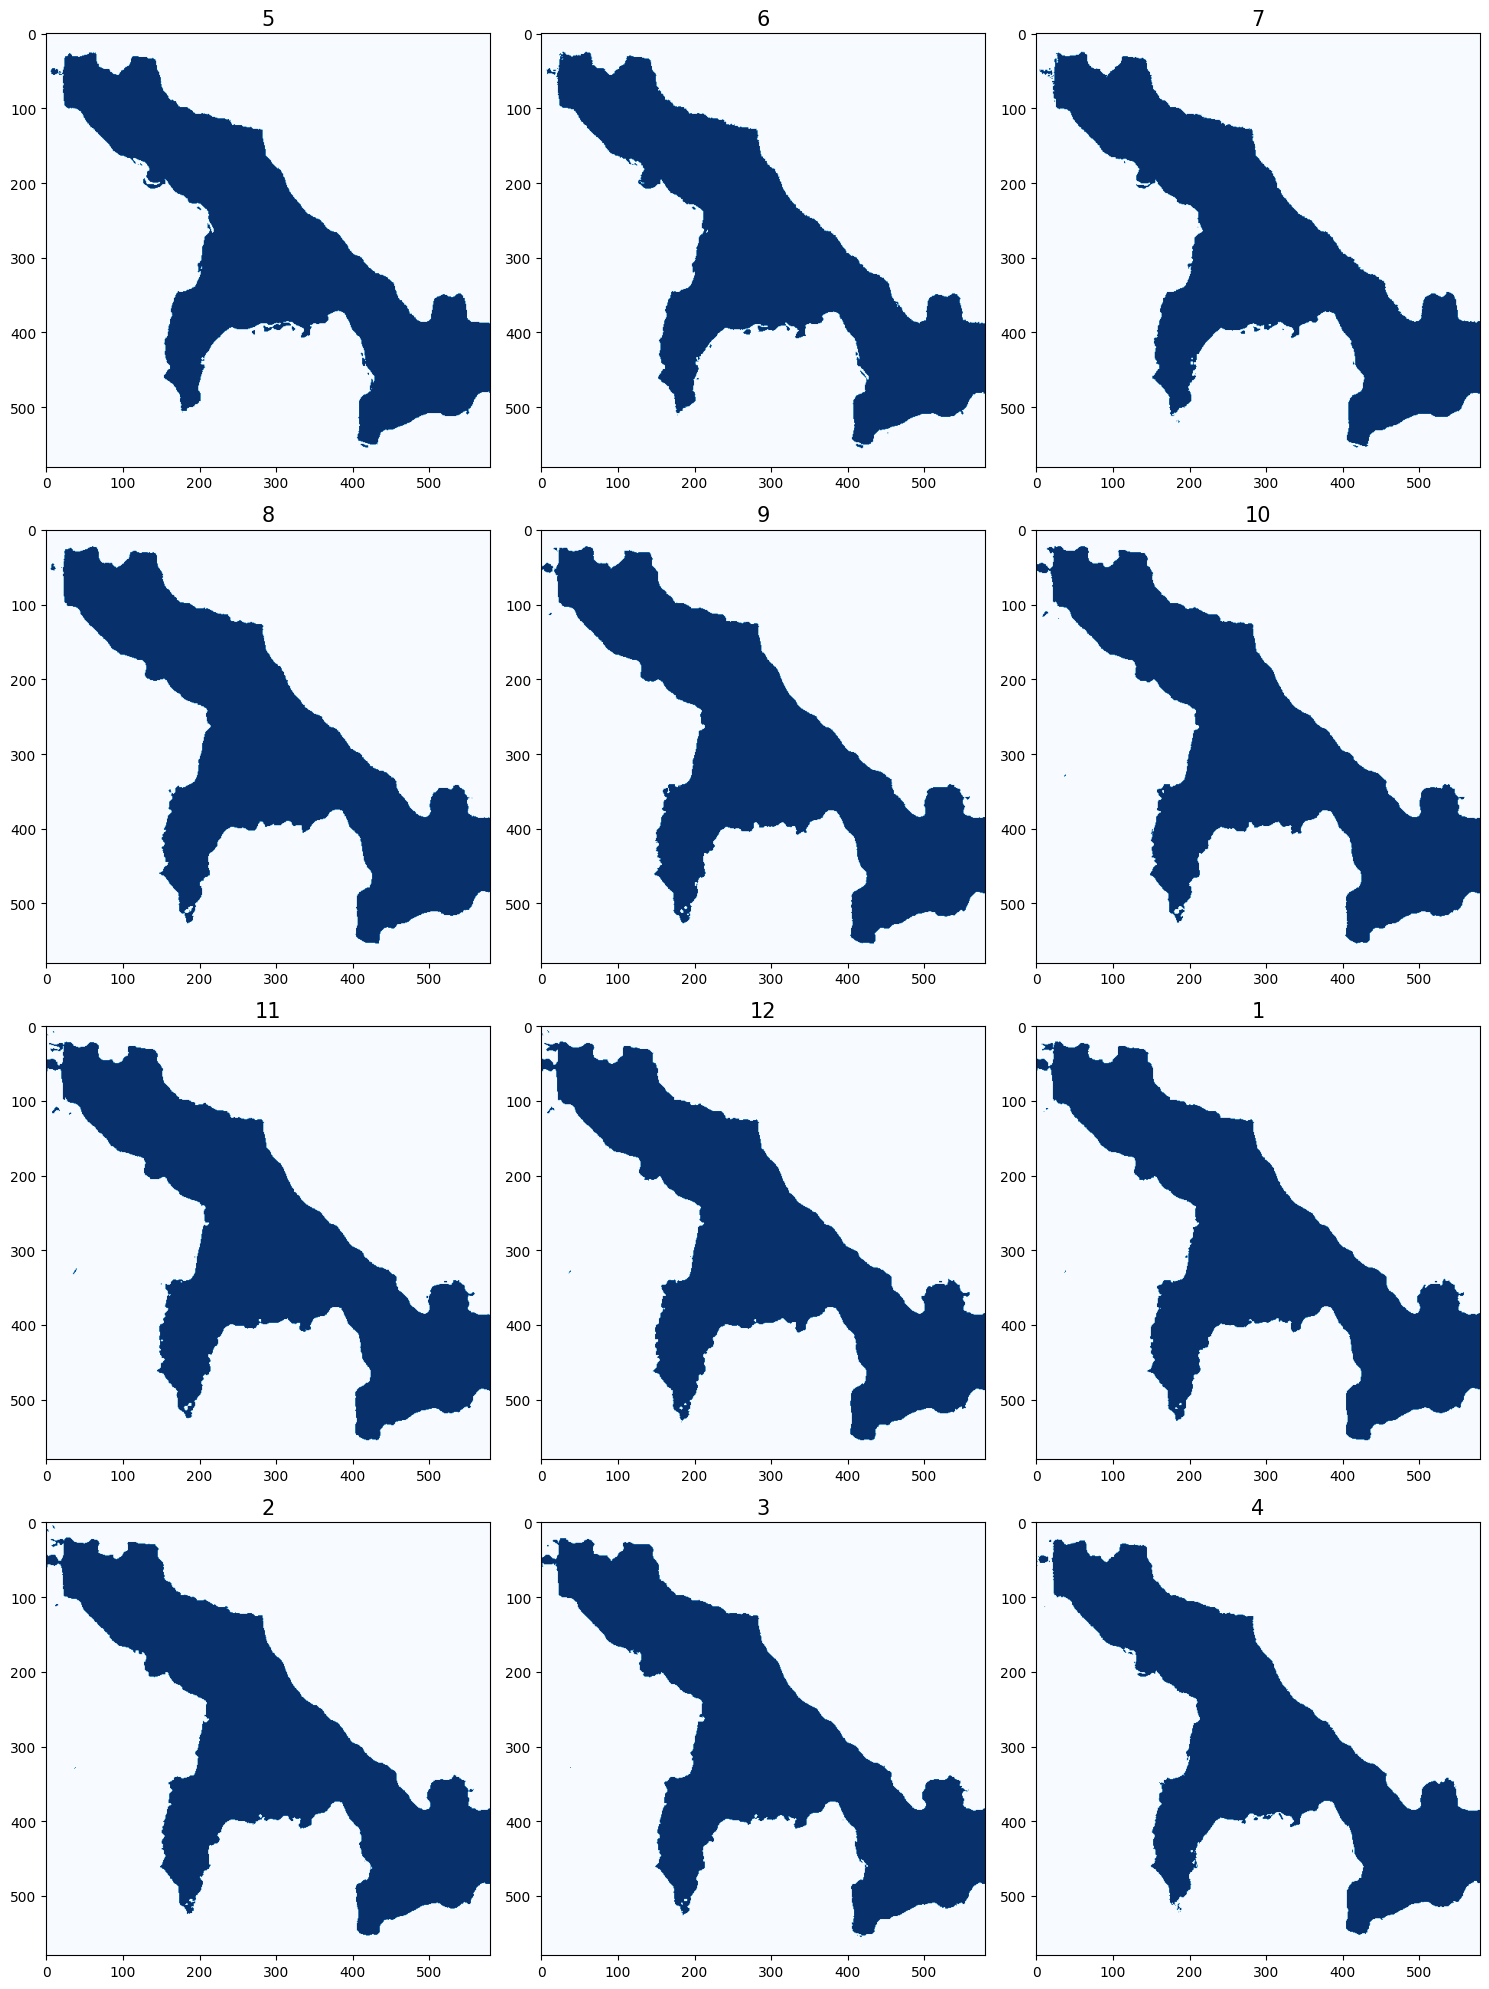

In [27]:


def plot_ndwi_array(ndwi_array, cmap="Blues"):
    # Create subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ndwi in enumerate(ndwi_array):
        # Plot each NDWI raster
        binary = ndwi > -0.40
        cax = axes[i].imshow(binary, cmap=cmap, aspect="auto")
        # Set title for each subplot
        axes[i].set_title(str((start_month + i - 1) % 12 + 1), fontsize=15)


    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming ndwi_list is a list of NDWI arrays
plot_ndwi_array(monthly_rasters)


Finally we can count the area of each month by counting the pixels above the monthly threshold. By plotting it we can see the water fluctuation of the Perth Water resevoir through the year.

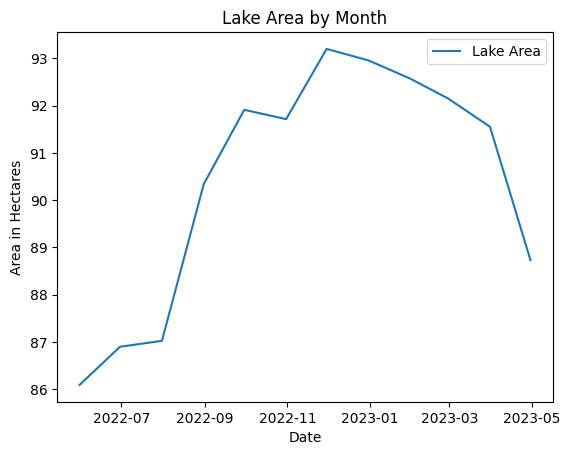

In [32]:
monthly_area = []
for i, ndwi in enumerate(monthly_rasters):
    monthly_area.append(np.sum(ndwi > -.40 )*9/10000)



# Plotting the data
plt.plot(monthly_mean.index,monthly_area, label='Lake Area')


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Area in Hectares')
plt.title('Lake Area by Month')
plt.legend()

# Displaying the plot
plt.show()

Our lake area does generally correlate with our earlier wetness/dryness although the largest water extent is measured as far earlier in the season then the wettest point. This basic analysis could be easily repeated year over year to get better annual trends and potentially detect anomalous events in the future!